<a href="https://colab.research.google.com/github/rahiakela/kaggle-competition-projects/blob/master/denoising-dirty-documents/01_denoising_images_using_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Denoising images using Autoencoders

##Setup

In [ ]:
!sudo apt-get install poppler-utils

In [ ]:
!pip install pdf2image

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Conv2DTranspose, Input
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
import cv2 
from pdf2image import convert_from_path
from io import BytesIO
from PIL import Image

In [ ]:
from google.colab import files
files.upload() # upload kaggle.json file

In [6]:
%%shell

mkdir -p ~/.kaggle
mv kaggle.json ~/.kaggle/
ls ~/.kaggle
chmod 600 /root/.kaggle/kaggle.json

# download dataset from kaggle> URL: https://www.kaggle.com/competitions/denoising-dirty-documents
kaggle competitions download -c denoising-dirty-documents

unzip -qq denoising-dirty-documents.zip

kaggle.json
 48% 17.0M/35.7M [00:00<00:00, 78.7MB/s]
100% 35.7M/35.7M [00:00<00:00, 117MB/s] 


In [7]:
# unzip files
with zipfile.ZipFile('train.zip', 'r') as zip_ref:
  zip_ref.extractall(".")

with zipfile.ZipFile('test.zip', 'r') as zip_ref:
  zip_ref.extractall(".")  
    
with zipfile.ZipFile('train_cleaned.zip', 'r') as zip_ref:
  zip_ref.extractall(".")  
    
with zipfile.ZipFile('sampleSubmission.csv.zip', 'r') as zip_ref:
  zip_ref.extractall(".")

##Image pre-processing

In [8]:
# store image names in list
train_img = sorted(os.listdir('./train'))
train_cleaned_img = sorted(os.listdir('./train_cleaned'))
test_img = sorted(os.listdir('./test'))

In [ ]:
train_img[:5]

['101.png', '102.png', '104.png', '105.png', '107.png']

In [17]:
def img_resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation=inter)

    # return the resized image
    return resized

In [20]:
# prepare function
def process_image(path):
  img = cv2.imread(path)
  img = np.asarray(img, dtype="float32")
  #print(img.shape)
  img = cv2.resize(img, (540, 420))  # (540, 420) and 2200, 1700
  #img = img_resize(img, width=2200, height=1700, inter=cv2.INTER_LINEAR)
  #print(img.shape)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = img/255.0
  img = np.reshape(img, (540, 420, 1))
  #print(img.shape)
  
  return img

In [21]:
# preprocess images
train = []
train_cleaned = []
test = []

for f in sorted(os.listdir('train/')):
  train.append(process_image('train/' + f))

for f in sorted(os.listdir('train_cleaned/')):
  train_cleaned.append(process_image('train_cleaned/' + f))
   
for f in sorted(os.listdir('test/')):
  test.append(process_image('test/' + f))

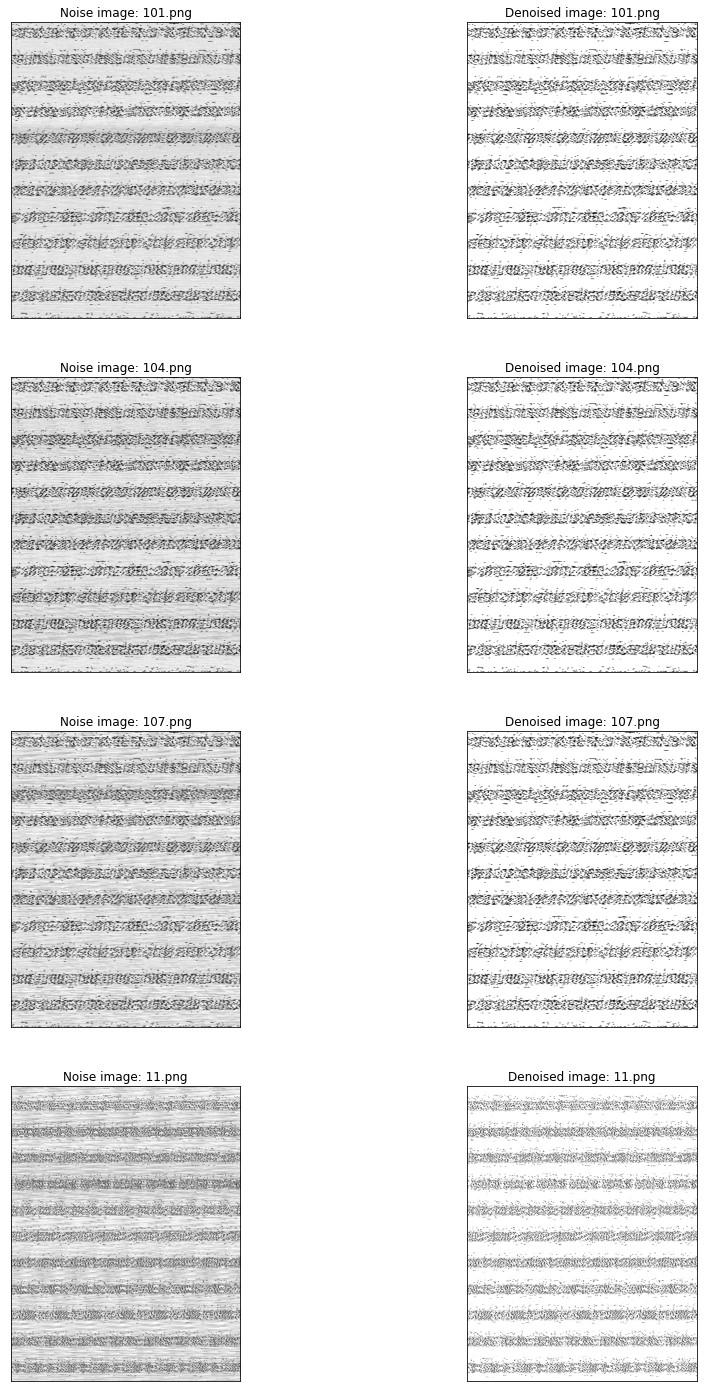

In [24]:
plt.figure(figsize=(15,25))
for i in range(0, 8, 2):
  plt.subplot(4,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(train[i][:,:,0], cmap='gray')
  plt.title('Noise image: {}'.format(train_img[i]))
  
  plt.subplot(4,2,i+2)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
  plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()

##CNN Autoencoders

In [ ]:
# convert list to numpy array
x_train = np.asarray(train)
y_train = np.asarray(train_cleaned)
x_test = np.asarray(test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15)

In [ ]:
conv_autoencoder = Sequential()

# Encoder
conv_autoencoder.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(420,540,1), activation='relu', padding='same'))
conv_autoencoder.add(MaxPooling2D((2, 2), padding='same'))

conv_autoencoder.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'))
conv_autoencoder.add(MaxPooling2D((2, 2), padding='same'))

# Decoder
conv_autoencoder.add(Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'))
conv_autoencoder.add(Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'))

# Output
conv_autoencoder.add(Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same'))

conv_autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 420, 540, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 210, 270, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 210, 270, 16)      4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 105, 135, 16)     0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 210, 270, 8)      1160      
 nspose)                                                         
                                                        

In [ ]:
conv_autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
history= conv_autoencoder.fit(x_train, y_train, validation_data = (x_val, y_val), epochs=200, batch_size=16, callbacks= [early_stop])

##Loss and Accuracy

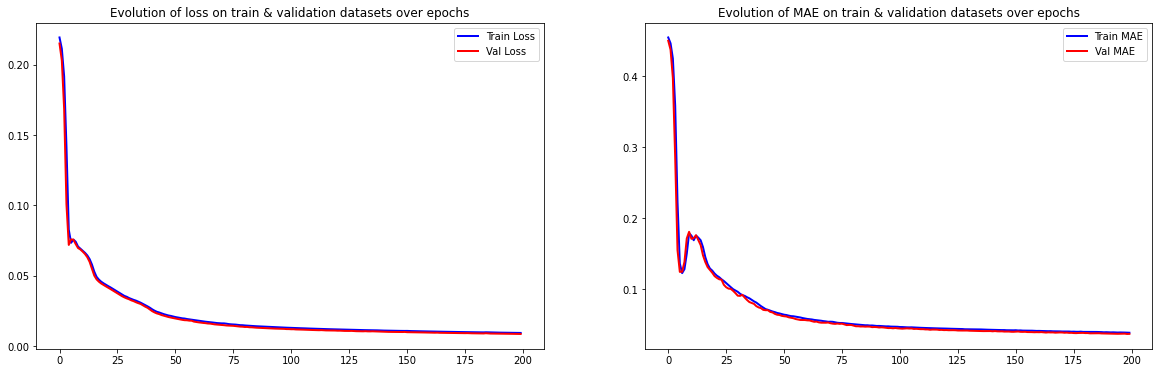

In [ ]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

##Prediction

In [ ]:
y_pred = conv_autoencoder.predict(x_test, batch_size=16)

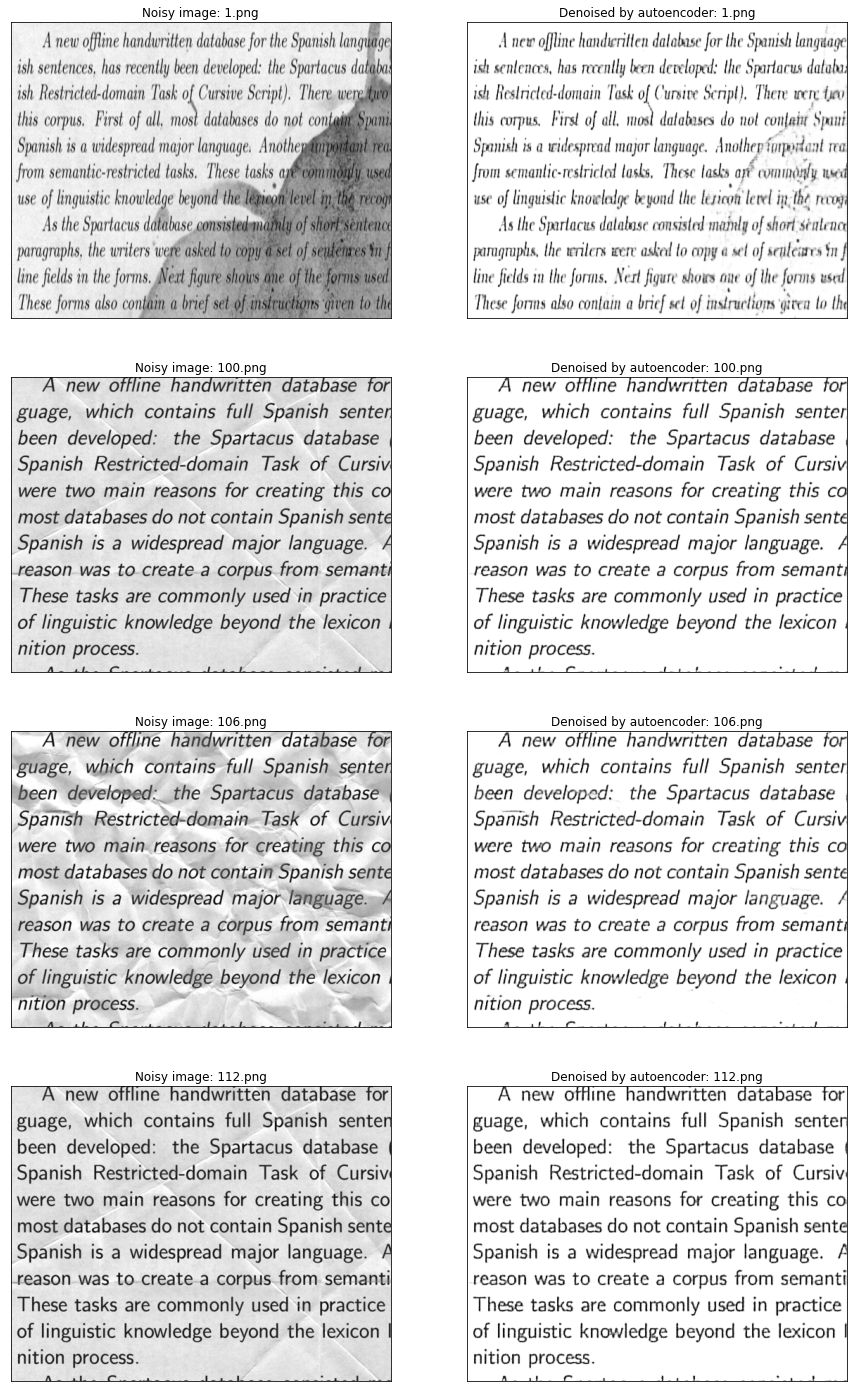

In [ ]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
  plt.subplot(4,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[i][:,:,0], cmap='gray')
  plt.title('Noisy image: {}'.format(test_img[i]))
  
  plt.subplot(4,2,i+2)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(y_pred[i][:,:,0], cmap='gray')
  plt.title('Denoised by autoencoder: {}'.format(test_img[i]))

plt.show()

In [ ]:
x_test[0].shape

(420, 540, 1)

##Denoising image

In [ ]:
def img_display(im_data):
    dpi = 80
    #im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

In [ ]:
pdf_file = 'document-page40.pdf'
pages = convert_from_path(pdf_file)
for page in pages:
  page.save("doc.jpg", "JPEG")

In [ ]:
image = cv2.imread("doc.jpg")
# Binarization
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
gray_image.shape

(2200, 1700)

In [ ]:
img_display(gray_image)

In [ ]:
#img_display(x_test[0])
plt.imshow(x_test[0][:,:,0], cmap='gray')

NameError: ignored

In [ ]:
resized_img = cv2.resize(x_test[0], (2200, 1700), interpolation=cv2.INTER_AREA)

In [ ]:
resized_img = resized_img[..., np.newaxis]
resized_img.shape

(1700, 2200, 1)

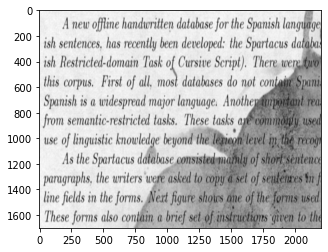

In [ ]:
plt.imshow(resized_img[:,:,0], cmap='gray')

In [ ]:
resized_img = cv2.resize(gray_image, (420, 540), interpolation=cv2.INTER_AREA)

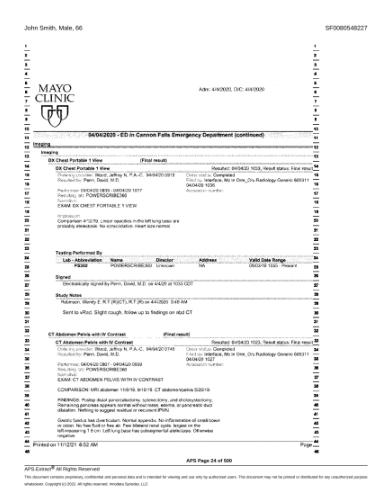

In [ ]:
img_display(resized_img)

In [ ]:
resized_img = resized_img[..., np.newaxis]
resized_img.shape

(540, 420, 1)

In [ ]:
y_pred = conv_autoencoder.predict(resized_img)

In [ ]:
y_pred[0]

array([[[1.],
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        [1.]]], dtype=float32)

In [ ]:
cv2.imwrite("out.png", y_pred)

False

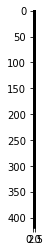

In [ ]:
#image = cv2.imread("doc.jpg")

# img_display(y_pred)
plt.imshow(y_pred[0][:,:,0], cmap='gray')